# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [296]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import isnan
from pyspark.sql.functions import to_date
from pyspark.sql.types import DateType

import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [297]:
# create a Spark session
spark = SparkSession \
       .builder \
       .appName("Sparkify-X") \
       .getOrCreate()

In [298]:
spark

In [299]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '2909db09f87a'),
 ('spark.app.name', 'Sparkify-X'),
 ('spark.app.id', 'local-1589885900640'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '37061'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [300]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [301]:
#Display first 3 rows - to get an idea
user_log.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [302]:
user_log.select("page").dropDuplicates().show(29)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [303]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [304]:
col_list = user_log.schema.names

In [305]:
col_list

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [306]:
user_log.count() #total entries

286500

In [307]:
empty_strings_dict = {}
for col in col_list:
 empty_strings_dict[col] = user_log.filter(user_log[col] == '').count()   

In [308]:
null_val_dict = {}
for col in col_list:
 null_val_dict[col] = user_log.filter(user_log[col].isNull()).count()


In [309]:
#dictionary - with number of null values for each colummn
null_val_dict

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

In [310]:
#dictionary - with number of emptry string for each colummn
empty_strings_dict

{'artist': 0,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 0,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 0,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 8346}

In [311]:
#drop the empty strings
user_log = user_log.filter(user_log['userId'] != "")
#check number of entries after dropping rows with empty strings
print(user_log.count())

278154


In [312]:
total_locations = user_log.select("location").dropDuplicates().sort("location").count()
location = user_log.select("location").dropDuplicates().sort("location")
print('total locations', total_locations)

total locations 114


In [313]:
user_log.select("registration").dropDuplicates().sort("registration").show()

+-------------+
| registration|
+-------------+
|1521380675000|
|1526739206000|
|1526838391000|
|1528403713000|
|1528560242000|
|1528772084000|
|1528780738000|
|1529027541000|
|1529252604000|
|1529643103000|
|1529934689000|
|1530306321000|
|1530333492000|
|1530514394000|
|1530674962000|
|1530763799000|
|1530789251000|
|1531281160000|
|1531350022000|
|1531679695000|
+-------------+
only showing top 20 rows



In [314]:
user_log.select("gender").dropDuplicates().sort("gender").show()
user_log.select("level").dropDuplicates().sort("level").show()
user_log.select("method").dropDuplicates().sort("method").show()
user_log.select("auth").dropDuplicates().sort("auth").show()
user_log.select("status").dropDuplicates().sort("status").show()

+------+
|gender|
+------+
|     F|
|     M|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   GET|
|   PUT|
+------+

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



In [315]:
user_log.select("userAgent").dropDuplicates().sort("userAgent").show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [316]:
user_log.select("itemInSession").dropDuplicates().sort("status").show()


+-------------+
|itemInSession|
+-------------+
|          720|
|         1258|
|          278|
|          964|
|           26|
|          474|
|          243|
|           65|
|         1224|
|           29|
|         1277|
|          558|
|          418|
|          541|
|          270|
|          222|
|          730|
|          938|
|         1145|
|          293|
+-------------+
only showing top 20 rows



In [317]:
user_log.select("length").dropDuplicates().sort("length").show()


+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
+--------+
only showing top 20 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [ ]:
#---FUNCTIONS---#

import matplotlib.pyplot as plt
#=============================================================
#
#=============================================================
def explore_data(df, target_col, exit):
    num = df[df['Churn'] == exit][[target_col]].drop_duplicates().count()
    #num = df.select([target_col]).filter(df.Churn == exit).dropDuplicates().count()
    return num

#=============================================================
#
#=============================================================
def plot_pie_chart(data1, data2, label1= 'Churned', label2='Not Churned'):
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
 labels = label1, label2
 sizes = [data1, data2]
 explode = (0, 0.1)  # only "explode" the 2nd slice - churned users

 fig1, ax1 = plt.subplots()
 ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
 ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

 plt.show()
    

#=============================================================
#
#============================================================= 
def get_total_number(df, cat_col, new_col):
 df[new_col] = df.groupby('userId')[cat_col].transform('sum')
 return df


#=============================================================
#
#=============================================================
def trend_over_time(df, eventcol, eventtype, time , xtitle , ytitle , kind = 'bar',heading1='Churned', heading2='Non Churned'):
    fig1, ax1 = plt.subplots(1,2)
    figsize=(12,5)

    ax1[0].set_xlabel(xtitle, fontsize=13)
    ax1[0].set_ylabel(ytitle, fontsize= 13)
    
    ax1[1].set_xlabel(xtitle, fontsize=13)
    ax1[1].set_ylabel(ytitle, fontsize= 13)
    
    y = df[df['Churn'] == '1'][[eventcol, time]]
    y[y[eventcol] == eventtype][time].value_counts(normalize=False).plot(kind=kind, use_index=True, title=heading1 ,figsize=figsize,ax=ax1[0])
    s = df[df['Churn'] == '0'][[eventcol, time]]
    s[s[eventcol] == eventtype][time].value_counts(normalize=False, sort=False).plot(kind=kind, use_index=True, title=heading2,figsize=figsize,ax=ax1[1])



#===========================================================
# Following piece of code taken from matplot lib examples and 
# modified according to the needs
#===========================================================
def plot_over_time(df, eventcol, eventtype, time , xtitle , ytitle , kind = 'bar',heading1='Churned', heading2='Non Churned'):
 y = df[df['Churn'] == '1'][[eventcol, time]]
 grp1 = y[y[eventcol] == eventtype][time].value_counts(normalize=False)

 s = df[df['Churn'] == '0'][[eventcol, time]]
 grp2 = s[s[eventcol] == eventtype][time].value_counts(normalize=False, sort=False)
 #labels = ['G1', 'G2']
 labels = grp1.index

 #men_means = [20, 34, 30, 35, 27]
 #women_means = [25, 32, 34, 20, 25]
 x = np.arange(len(labels))  # the label locations
 width = 0.35  # the width of the bars

 fig, ax = plt.subplots()
 rects1 = ax.bar(x - width/2, grp1, width, label=heading1)
 rects2 = ax.bar(x + width/2, grp2, width, label=heading2)

 # Add some text for labels, title and custom x-axis tick labels, etc.
 ax.set_ylabel(ytitle)
 ax.set_xlabel(xtitle)
 ax.set_title('Scores by Event '+eventtype)
 ax.set_xticks(x)
 ax.set_xticklabels(labels)
 ax.legend()


 def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


 autolabel(rects1)
 autolabel(rects2)

 fig.tight_layout()

 plt.show()
    
#--------------------------------------------------------------------------#   
#Following code is taken from the following link - it is not written by me-
#https://www.kaggle.com/bandiang2/prediction-of-customer-churn-at-a-bank
#--------------------------------------------------------------------------#   

#function  for pie plot for customer attrition types
import plotly.graph_objs as go #visualization
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization

def plot_pie(column):
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)

In [318]:
#GET USERS WHO CHURNED
churned_users = user_log.select(["userId"]).filter(user_log.page == "Cancellation Confirmation")
churned_users = churned_users.toPandas()
churned_users = churned_users.userId.tolist()

In [319]:
churned_users

['18',
 '32',
 '125',
 '105',
 '17',
 '143',
 '101',
 '129',
 '121',
 '51',
 '87',
 '122',
 '12',
 '58',
 '73',
 '3',
 '106',
 '103',
 '28',
 '54',
 '29',
 '70',
 '53',
 '100011',
 '100001',
 '100024',
 '100006',
 '100019',
 '100003',
 '100023',
 '100005',
 '100017',
 '100025',
 '100009',
 '100012',
 '100013',
 '100022',
 '100014',
 '100015',
 '100021',
 '100007',
 '200001',
 '200024',
 '200011',
 '200021',
 '200018',
 '200015',
 '200017',
 '200016',
 '200020',
 '300007',
 '300001']

In [320]:
get_churn_users = udf(lambda x: 1 if( x in churned_users) else 0)

In [321]:
#Create Churn column and mark it 1 for users who churned
user_log = user_log.withColumn('Churn', get_churn_users("userId"))

In [322]:
user_log.select("Churn").dropDuplicates().show()

+-----+
|Churn|
+-----+
|    0|
|    1|
+-----+



In [323]:
#Decode timestamp into hour and month
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)
user_log = user_log.withColumn("hour", get_hour(user_log.ts))
user_log = user_log.withColumn("month", get_month(user_log.ts))

In [324]:
user_log.take(2)


[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn='0', hour='0', month='10'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', Churn='0', hour='0', month='10')]

In [325]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.Churn , user_log.hour).count().orderBy(user_log.hour.cast("float"))
songs_in_hour.show(24)

+-----+----+-----+
|Churn|hour|count|
+-----+----+-----+
|    0|   0| 7527|
|    1|   0| 1535|
|    0|   1| 7035|
|    1|   1| 1353|
|    1|   2| 1322|
|    0|   2| 7014|
|    0|   3| 7063|
|    1|   3| 1292|
|    0|   4| 6914|
|    1|   4| 1233|
|    0|   5| 6960|
|    1|   5| 1218|
|    0|   6| 6836|
|    1|   6| 1218|
|    1|   7| 1218|
|    0|   7| 6873|
|    1|   8| 1230|
|    0|   8| 7023|
|    1|   9| 1230|
|    0|   9| 7268|
|    0|  10| 7502|
|    1|  10| 1380|
|    1|  11| 1390|
|    0|  11| 7440|
+-----+----+-----+
only showing top 24 rows



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
Churn    48 non-null object
hour     48 non-null object
count    48 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.2+ KB
None


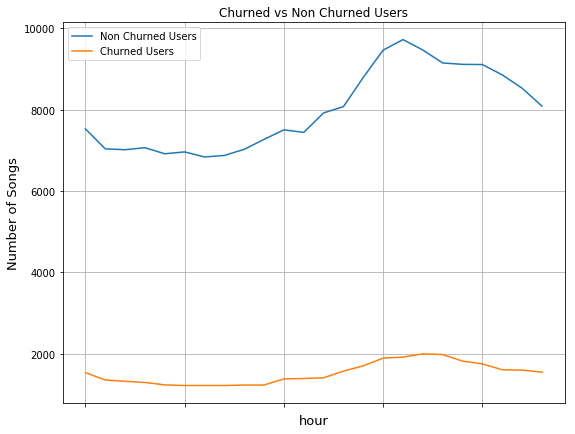

In [327]:
#Convert to Pandas for visualization
#Number of songs in 24 hours aggregated for churned and non churned users 

churn_usr_songs = songs_in_hour.toPandas()
print(churn_usr_songs.info())
churn_usr_songs['Churn'].value_counts()
ax = plt.gca()
ax.set_xlabel('Hours from 0-24', fontsize=13)
ax.set_ylabel('Number of Songs', fontsize= 13)

churn_usr_songs.groupby('Churn').plot(x='hour',y='count',title = 'Churned vs Non Churned Users' ,use_index=True,figsize = (9,7) ,legend = True, grid = True, ax=ax)
ax.legend(["Non Churned Users", "Churned Users"]);

In [328]:
#-Convert user_log to PANDAS for further exploration --#

from datetime import datetime
from datetime import date


df_user_log     = user_log.toPandas()
df_user_log.info()

#Decode ts column into time, day, month and year
df_user_log['time']  = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). hour))
df_user_log['day']   = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). day))
df_user_log['month'] = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). month))
df_user_log['year']  = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). year))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 21 columns):
artist           228108 non-null object
auth             278154 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    278154 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            278154 non-null object
location         278154 non-null object
method           278154 non-null object
page             278154 non-null object
registration     278154 non-null int64
sessionId        278154 non-null int64
song             228108 non-null object
status           278154 non-null int64
ts               278154 non-null int64
userAgent        278154 non-null object
userId           278154 non-null object
Churn            278154 non-null object
hour             278154 non-null object
month            278154 non-null object
dtypes: float64(1), int64(5), object(15)
memory usage

In [329]:
df_user_log.head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,status,ts,userAgent,userId,Churn,hour,month,time,day,year
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,0,10,0,1,2018
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,0,10,0,1,2018
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,0,10,0,1,2018


In [330]:
#REMOVING OUTLIER - DECEMEBER ONLY 4 ENTRIES
print(df_user_log[df_user_log['month'] == 12][['userId', 'month']].head(5))
df_user_log = df_user_log.drop(df_user_log[df_user_log.month == 12].index)

        userId  month
207497     152     12
219898  100002     12
241225  200008     12
278153  300011     12


In [332]:
total_users = df_user_log['userId'].drop_duplicates().count()

num_churned_user    = explore_data(df_user_log, "userId", "1")
num_non_churned_user = explore_data(df_user_log,"userId", "0")

num_males   = df_user_log[df_user_log['gender'] == "M"][['userId']].drop_duplicates().count()
num_females = df_user_log[df_user_log['gender'] == "F"][['userId']].drop_duplicates().count()

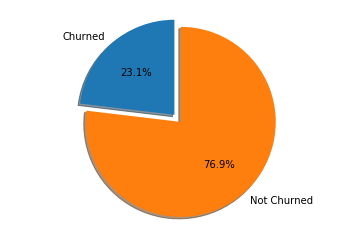

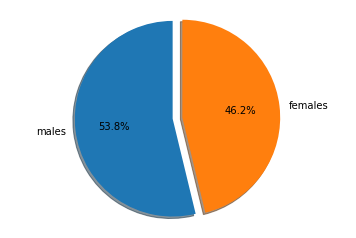

In [333]:
#--PLOT--#
plot_pie_chart(num_churned_user, num_non_churned_user)
plot_pie_chart(num_males, num_females, 'males', 'females')


In [334]:
print("TOTAL USERS:", total_users)
print("CHURNED USERS:",    num_churned_user.values)
print("NON CHURNED USERS:", num_non_churned_user.values)

TOTAL USERS: 225
CHURNED USERS: [52]
NON CHURNED USERS: [173]


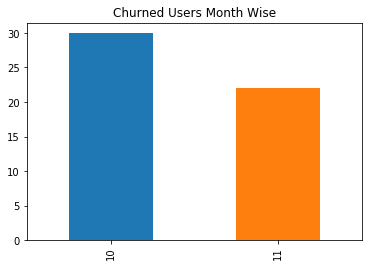

In [335]:
churned_timewise = df_user_log[df_user_log['page'] == 'Cancellation Confirmation'][['day', 'month']]
churned_timewise['month'].value_counts(sort=False).plot(kind='bar', use_index=True, title='Churned Users Month Wise')

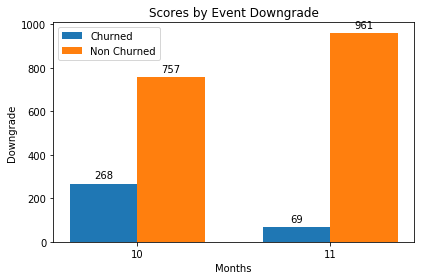

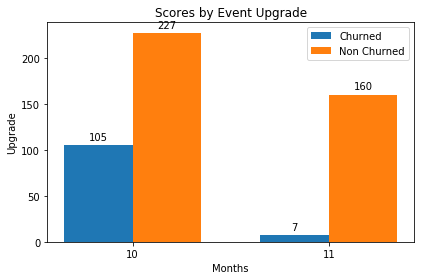

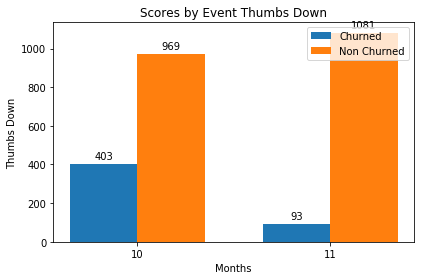

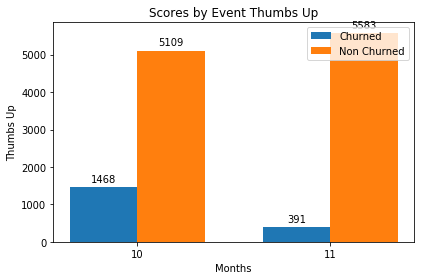

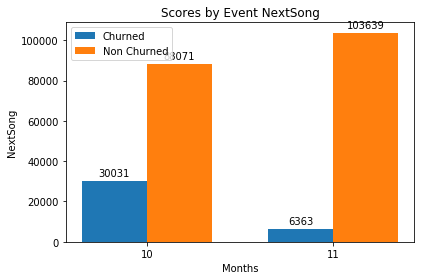

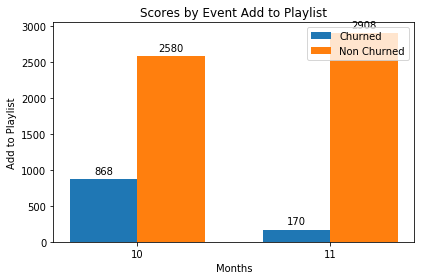

In [336]:
#Plot events month wise for Churned and Non Churned Users
to_plot = ['Downgrade', 'Upgrade', 'Thumbs Down' , 'Thumbs Up', 'NextSong', 'Add to Playlist']
for i in to_plot:
 plot_over_time(df_user_log, 'page' , i, 'month' , 'Months' , i)

In [337]:
#Get all the event names from page column
page_events_name = df_user_log['page'].unique()
page_events_name = list(page_events_name)

#-Convert Categorical Columns
df_events = pd.get_dummies(df_user_log, columns=['gender','level', 'page'])

#Create new column for example: num_NextSong
# sum all the events for each user and update respective event column
for name in page_events_name:
 df_events = get_total_number(df_events, 'page_'+name,'num_'+name)

df_events.columns 
print(df_events.shape)

(278150, 63)


In [338]:
#Since all the events for each user are summed up, drop other entries and keep only one entry for each user id
df_events = df_events.drop_duplicates(subset=['userId'], keep='first')
print(df_events.shape)


(225, 63)


In [339]:
df_events.head(3)

,artist,auth,firstName,itemInSession,lastName,length,location,method,registration,sessionId,...,num_Upgrade,num_Add Friend,num_Settings,num_Submit Upgrade,num_About,num_Submit Downgrade,num_Error,num_Save Settings,num_Cancel,num_Cancellation Confirmation
0,Martha Tilston,Logged In,Colin,50,Freeman,277.89016,"Bakersfield, CA",PUT,1538173362000,29,...,14,25,13,1,3,1,1,1,0,0
1,Five Iron Frenzy,Logged In,Micah,79,Long,236.09424,"Boston-Cambridge-Newton, MA-NH",PUT,1538331630000,8,...,6,40,12,2,9,1,3,1,0,0
17,Tokyo Police Club,Logged In,Ashlynn,0,Williams,166.11220,"Tallahassee, FL",PUT,1537365219000,217,...,3,43,17,2,4,1,1,1,0,0


In [340]:
plot_pie('gender')

In [341]:
plot_pie('page')

In [342]:
plot_pie('auth')

In [343]:
plot_pie('level')

In [344]:
plot_pie('method')

In [345]:
plot_pie('status')

In [346]:
plot_pie('location')

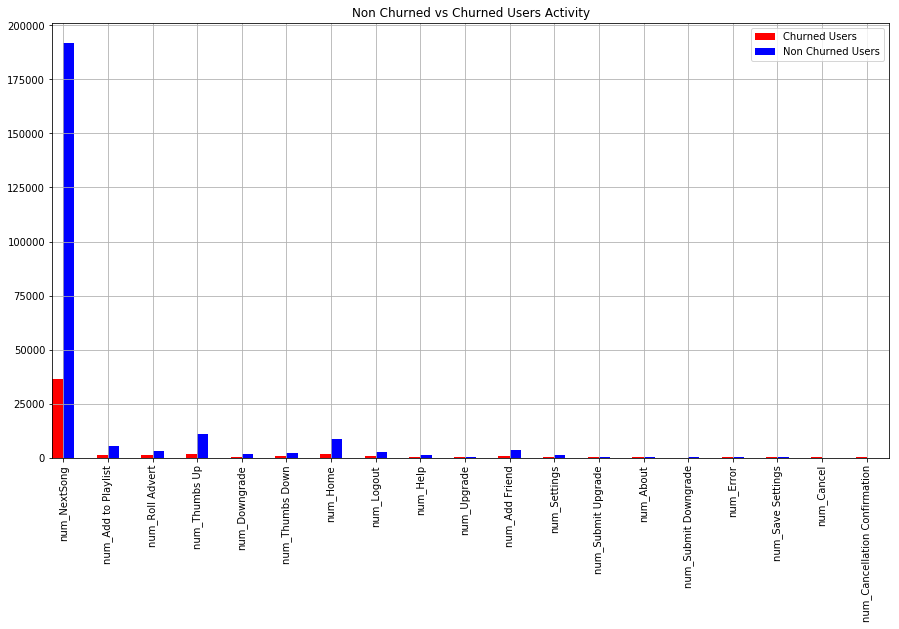

In [347]:
cmap1 = cm.get_cmap('autumn') # Colour map (there are many others)
cmap2 = cm.get_cmap('brg') # Colour map (there are many others)
ax = plt.gca()
tt[tt['Churn'] == '1'][cols_to_plot].sum().plot(kind='bar',width=0.25, alpha=1,figsize=(15,8), title="Churned Users Activity" , colormap = cmap1 ,position=1, ax=ax)
tt[tt['Churn'] == '0'][cols_to_plot].sum().plot(kind='bar',width=0.25,figsize=(15,8),title="Non Churned vs Churned Users Activity",  colormap = cmap2 ,position=0, ax=ax, grid=True)
ax.legend(["Churned Users","Non Churned Users"]);

In [348]:
df_events['location'].value_counts().head(5)

Los Angeles-Long Beach-Anaheim, CA       16
New York-Newark-Jersey City, NY-NJ-PA    15
Phoenix-Mesa-Scottsdale, AZ               7
Dallas-Fort Worth-Arlington, TX           7
Chicago-Naperville-Elgin, IL-IN-WI        6
Name: location, dtype: int64

In [386]:
#import seaborn as sn

#cols_to_plot=  []
#for name in cat_col_names:
#  cols_to_plot.append('num_'+name)
#print(cols_to_plot)
#fig, ax = plt.subplots(figsize=(8,8))  
#df_tmp = df_events[cols_to_plot]
#print(df_tmp.shape)
#corrMatrix= df_tmp[cols_to_plot].corr()
#sn.heatmap(corrMatrix, annot=True)
#plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [350]:
df_events[df_events.isna()].count()
df_events.columns
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 0 to 252939
Data columns (total 63 columns):
artist                            110 non-null object
auth                              225 non-null object
firstName                         225 non-null object
itemInSession                     225 non-null int64
lastName                          225 non-null object
length                            110 non-null float64
location                          225 non-null object
method                            225 non-null object
registration                      225 non-null int64
sessionId                         225 non-null int64
song                              110 non-null object
status                            225 non-null int64
ts                                225 non-null int64
userAgent                         225 non-null object
userId                            225 non-null object
Churn                             225 non-null object
hour                            

In [351]:
feature_df_pd = df_events[['userId', 
                           'gender_F',
                           'gender_M',
                           'level_free',
                           'level_paid',
                           'num_NextSong', 
                           'Churn']]
feature_df_pd.head()

,userId,gender_F,gender_M,level_free,level_paid,num_NextSong,Churn
0,30,0,1,0,1,1417.0,0
1,9,0,1,1,0,2676.0,0
17,74,1,0,1,0,2400.0,0
22,54,1,0,0,1,2841.0,1
70,4,0,1,1,0,2048.0,0


In [352]:
#Convert Pandas Data Frame to Spark - for machine learning
feature_spark_df = spark.createDataFrame(feature_df_pd)


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [353]:
feature_spark_df.columns[1:6]

['gender_F', 'gender_M', 'level_free', 'level_paid', 'num_NextSong']

In [354]:
feature_spark_df.describe().show()

+-------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+
|summary|            userId|          gender_F|           gender_M|        level_free|         level_paid|      num_NextSong|              Churn|
+-------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+
|  count|               225|               225|                225|               225|                225|               225|                225|
|   mean|65391.013333333336|0.4622222222222222| 0.5377777777777778|0.7866666666666666|0.21333333333333335|1013.7955555555556| 0.2311111111111111|
| stddev|105396.47791907165|0.4996824388374478|0.49968243883744784|0.4105745103771404| 0.4105745103771404|1104.9452850778964|0.42248321089963264|
|    min|                10|                 0|                  0|                 0|                  0|               3.0

In [355]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler 
from pyspark.ml.feature import StringIndexer 
from pyspark.mllib.tree import RandomForest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator    
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier

In [356]:
def get_accuracy(result):
 true_pred_count = result.filter(result.label == result.prediction).count()
 print("Correct prediction:", true_pred_count)
 print("Total values:", result.count())
 print("Accuracy:" ,true_pred_count/result.count())

In [357]:
def get_eval_metrics(df):
 predictionRDD = df.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
 metrics = MulticlassMetrics(predictionRDD)
 print("Precision:", metrics.precision())
 print("Accuracy:", metrics.accuracy)
 print("Recall:", metrics.recall())
 print("F1:", metrics.fMeasure())  
 print("Weighted Precision:",metrics.weightedPrecision)
 print("Weighted Recall:",metrics.weightedRecall)
 print("Weighted F1:",metrics.weightedFMeasure())

In [358]:
#def config_pipeline(assembler, scaler, indexer,model):
#    pipeline = Pipeline(stages=[assembler, scaler, indexer, model])
#    return pipeline

In [359]:
def config_pipeline(assembler, indexer,model):
    pipeline = Pipeline(stages=[assembler, indexer, model])
    return pipeline

#scaler    = StandardScaler(inputCol="features", outputCol="scaled_features",withStd=False, withMean=True)

In [360]:
(trainingData, testData) = feature_spark_df.randomSplit([0.7, 0.3])

In [361]:
assembler = VectorAssembler(inputCols=feature_spark_df.columns[1:6], outputCol="features")
indexer = StringIndexer(inputCol="Churn", outputCol="label")

In [362]:
#Define all the algorithms which we are going to use
rf           = RandomForestClassifier(featuresCol="features", labelCol="label", maxDepth=5, numTrees=20)
logistic_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=50)
d_tree       = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 5)
grad_bt      = GBTClassifier(featuresCol = 'features', labelCol = 'label',maxIter=50)

# Select (prediction, true label) and compute test error
#evaluator = BinaryClassificationEvaluator(labelCol="Churn")
evaluator = BinaryClassificationEvaluator()

In [363]:
#Define all the algorithms which we are going to use
#rf           = RandomForestClassifier(featuresCol="features", labelCol="label", maxDepth=5, numTrees=20)
#rf           = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", maxDepth=5, numTrees=20)
#logistic_reg = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'label', maxIter=50)
#d_tree       = DecisionTreeClassifier(featuresCol = 'scaled_features', labelCol = 'label', maxDepth = 5)
#grad_bt      = GBTClassifier(maxIter=50)

# Select (prediction, true label) and compute test error
#evaluator = BinaryClassificationEvaluator(labelCol="Churn")
evaluator = BinaryClassificationEvaluator()

In [364]:
#pipeline_rf = config_pipeline(assembler, scaler, indexer,rf)
#result.printSchema()
#eval_metric = BinaryClassificationMetrics(result)

In [365]:
#RandomForest
pipeline_rf = config_pipeline(assembler, indexer,rf)
pmodel = pipeline_rf.fit(trainingData)
result = pmodel.transform(testData)
result.select('userId', 'label', 'rawPrediction' , 'probability' , 'prediction').show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|100005|  1.0|[16.6525400489548...|[0.83262700244774...|       0.0|
|100006|  1.0|[13.6620682448505...|[0.68310341224252...|       0.0|
|100009|  1.0|[16.8296588543637...|[0.84148294271818...|       0.0|
|100010|  0.0|[14.7658886934078...|[0.73829443467039...|       0.0|
|100022|  1.0|[16.6110405070808...|[0.83055202535404...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [366]:
roc  = evaluator.evaluate(result)
print('ROC Value', roc)
get_accuracy(result)
get_eval_metrics(result)

ROC Value 0.5789215686274509
Correct prediction: 50
Total values: 71
Accuracy: 0.704225352112676
Precision: 0.704225352112676
Accuracy: 0.704225352112676
Recall: 0.704225352112676
F1: 0.704225352112676
Weighted Precision: 0.5130784708249497
Weighted Recall: 0.704225352112676
Weighted F1: 0.5936445116982889


In [367]:
#c =result.toPandas()
#c[['userId', 'label' , 'probability' , 'rawPrediction', 'prediction']].head(20)
#x= pmodel.stages[2]
#result.select( 'features','scaled_features').take(2)

In [368]:
result.select('userId', 'gender_F', 'gender_M' ,'level_free' ,'level_paid', 'num_NextSong', 'Churn', 'features','label').take(5)

[Row(userId='100005', gender_F=0, gender_M=1, level_free=1, level_paid=0, num_NextSong=154.0, Churn='1', features=DenseVector([0.0, 1.0, 1.0, 0.0, 154.0]), label=1.0),
 Row(userId='100006', gender_F=1, gender_M=0, level_free=1, level_paid=0, num_NextSong=26.0, Churn='1', features=DenseVector([1.0, 0.0, 1.0, 0.0, 26.0]), label=1.0),
 Row(userId='100009', gender_F=0, gender_M=1, level_free=1, level_paid=0, num_NextSong=518.0, Churn='1', features=DenseVector([0.0, 1.0, 1.0, 0.0, 518.0]), label=1.0),
 Row(userId='100010', gender_F=1, gender_M=0, level_free=1, level_paid=0, num_NextSong=275.0, Churn='0', features=DenseVector([1.0, 0.0, 1.0, 0.0, 275.0]), label=0.0),
 Row(userId='100022', gender_F=1, gender_M=0, level_free=1, level_paid=0, num_NextSong=681.0, Churn='1', features=DenseVector([1.0, 0.0, 1.0, 0.0, 681.0]), label=1.0)]

In [369]:
#Gradient BT Classifier
pipeline_grad  = config_pipeline(assembler, indexer,grad_bt)
grad_model     = pipeline_grad.fit(trainingData)
grad_pred      = grad_model.transform(testData)
grad_pred.select('userId', 'label', 'rawPrediction' , 'probability' , 'prediction').show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|100005|  1.0|[1.39659265681428...|[0.94230645846222...|       0.0|
|100006|  1.0|[1.16990096891966...|[0.91212021041135...|       0.0|
|100009|  1.0|[1.79911640734281...|[0.97335721641810...|       0.0|
|100010|  0.0|[0.55381522757446...|[0.75168709116404...|       0.0|
|100022|  1.0|[1.69121847125613...|[0.96715111466597...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [370]:
print('ROC:',evaluator.evaluate(grad_pred))
get_eval_metrics(grad_pred)

ROC: 0.4764705882352942
Precision: 0.6619718309859155
Accuracy: 0.6619718309859155
Recall: 0.6619718309859155
F1: 0.6619718309859155
Weighted Precision: 0.5552907186710003
Weighted Recall: 0.6619718309859155
Weighted F1: 0.5913624985990212


In [371]:
#Logistic Regression 
pipeline_lr    =  config_pipeline(assembler, indexer,logistic_reg)
lrModel        = pipeline_lr.fit(trainingData)
lrModel_pred = lrModel.transform(testData)
lrModel_pred.select('userId', 'label', 'rawPrediction' , 'probability' , 'prediction').show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|100005|  1.0|[0.94155468131687...|[0.71941358880003...|       0.0|
|100006|  1.0|[0.77533650378097...|[0.68467415447519...|       0.0|
|100009|  1.0|[1.11357987395405...|[0.75279590804632...|       0.0|
|100010|  0.0|[0.89301307786519...|[0.70951157448387...|       0.0|
|100022|  1.0|[1.08488733119128...|[0.74741775069330...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [372]:
eval_result  = evaluator.evaluate(lrModel_pred)
get_eval_metrics(lrModel_pred)
print("ROC:",eval_result)
#get_accuracy(lrModel_pred)

Precision: 0.7183098591549296
Accuracy: 0.7183098591549296
Recall: 0.7183098591549296
F1: 0.7183098591549296
Weighted Precision: 0.5159690537591748
Weighted Recall: 0.7183098591549296
Weighted F1: 0.6005541445393674
ROC: 0.5774509803921569


In [373]:
#Decesion Tree
pipeline_dt   =  config_pipeline(assembler, indexer,d_tree)
dtModel = pipeline_dt.fit(trainingData)
dt_pred = dtModel.transform(testData)
dt_pred.select('userId', 'label', 'rawPrediction' , 'probability' , 'prediction').show(5)

+------+-----+-------------+--------------------+----------+
|userId|label|rawPrediction|         probability|prediction|
+------+-----+-------------+--------------------+----------+
|100005|  1.0|   [26.0,3.0]|[0.89655172413793...|       0.0|
|100006|  1.0|    [7.0,3.0]|           [0.7,0.3]|       0.0|
|100009|  1.0|   [19.0,0.0]|           [1.0,0.0]|       0.0|
|100010|  0.0|    [2.0,3.0]|           [0.4,0.6]|       1.0|
|100022|  1.0|   [19.0,0.0]|           [1.0,0.0]|       0.0|
+------+-----+-------------+--------------------+----------+
only showing top 5 rows



In [374]:
eval_result  = evaluator.evaluate(dt_pred)
get_eval_metrics(dt_pred)
print("ROC:",eval_result)
#get_accuracy(dt_pred)

Precision: 0.6338028169014085
Accuracy: 0.6338028169014085
Recall: 0.6338028169014085
F1: 0.6338028169014085
Weighted Precision: 0.5368879946344735
Weighted Recall: 0.6338028169014084
Weighted F1: 0.5746055279042677
ROC: 0.4274509803921569


In [375]:
print(d_tree.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
m

In [376]:
#paramGrid = (ParamGridBuilder. 
#    .addGrid(rf.numTrees, [3, 10])
#    .addGrid(...)  # Add other parameters
#    .build())
# Set F-1 score as evaluation metric for best model selection
evaluator_ = MulticlassClassificationEvaluator(labelCol='label',
                                              predictionCol='prediction', metricName='f1')   

#Following two parameters chosen because of recommendation in spark api documentation
paramGrid = ParamGridBuilder() \
           .addGrid(d_tree.maxDepth, [5,8,10,12]) \
           .build()

cv = CrossValidator(estimator=pipeline_dt,                         
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_,
                    numFolds=3)  # use 3+ folds in practice

# Train model.  This also runs the indexers.
tuned_model = cv.fit(trainingData)
tuned_results = tuned_model.transform(testData)

In [377]:
get_eval_metrics(tuned_results)
print (evaluator_.getMetricName(), 'accuracy:', evaluator_.evaluate(tuned_results))

Precision: 0.6901408450704225
Accuracy: 0.6901408450704225
Recall: 0.6901408450704225
F1: 0.6901408450704225
Weighted Precision: 0.5850325835610678
Weighted Recall: 0.6901408450704225
Weighted F1: 0.6078618604281053
f1 accuracy: 0.6078618604281053


In [378]:
#paramGrid = (ParamGridBuilder. 
#    .addGrid(rf.numTrees, [3, 10])
#    .addGrid(...)  # Add other parameters
#    .build())
# Set F-1 score as evaluation metric for best model selection
evaluator_ = MulticlassClassificationEvaluator(labelCol='label',
                                              predictionCol='prediction', metricName='f1')   

#Following two parameters chosen because of recommendation in spark api documentation
paramGrid = ParamGridBuilder() \
           .addGrid(rf.maxDepth, [5,8,10,12]) \
           .addGrid(rf.numTrees, [8,10,12,15,20,25]) \
           .build()

cv = CrossValidator(estimator=pipeline_rf,                         
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_,
                    numFolds=4)

# Train model.  This also runs the indexers.
tuned_model = cv.fit(trainingData)
info = tuned_model.bestModel.stages[2]
print(info)
tuned_results = tuned_model.transform(testData)

RandomForestClassificationModel (uid=RandomForestClassifier_3d62b503738d) with 12 trees


In [379]:
#print(tuned_model.avgMetrics)


In [380]:
#tuned_results = tuned_model.transform(testData)

In [381]:
print(tuned_results.filter(tuned_results.label == tuned_results.prediction).count())
print(tuned_results.count())

50
71


In [382]:
print (evaluator_.getMetricName(), 'accuracy:', evaluator_.evaluate(tuned_results))

f1 accuracy: 0.5936445116982889


In [383]:
get_eval_metrics(tuned_results)

Precision: 0.704225352112676
Accuracy: 0.704225352112676
Recall: 0.704225352112676
F1: 0.704225352112676
Weighted Precision: 0.5130784708249497
Weighted Recall: 0.704225352112676
Weighted F1: 0.5936445116982889


In [384]:

#tree_model = CV_model.bestModel.stages[2]
#print tree_model

In [385]:
#rfModel = pmodel.stages[3]
#importances = rfModel.featureImportances
#gives sparse vector
#importances
#features_label = feature_df_pd.columns
#import numpy as np
#indices = np.argsort(importances)[::-1]
#indices
#importances[int(indices[1])]

#for i in range(1,feature_df_pd.shape[1] -1):     
#   print ("%2d) %-*s %f" % (i + 1, 30, features_label[i], importances[int(indices[i])] )) 
   #print(features_label[i], importances[indices[i]])            

IndexError: list index out of range

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.